Lets Get Started

Image Segmentation using K-means (numpy only)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


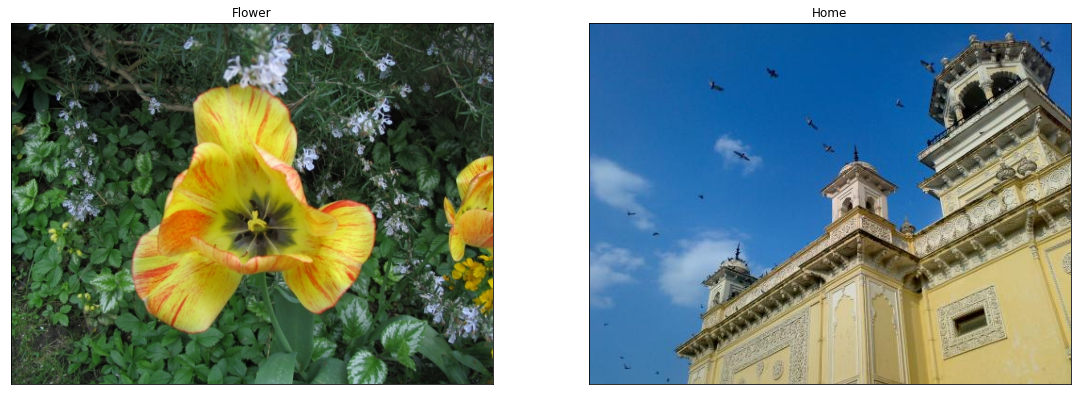

In [82]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import numpy as np
import os

%matplotlib inline
from google.colab import drive
drive.mount('/content/drive')
path = "/content/drive/My Drive/ECSE_415/Assignment_4" #change your image path here to work on whole assignment
# Read in the image
flower = cv2.imread(path+'/flower.jpg') 
home = cv2.imread(path+'/home.jpg') 
flower = cv2.cvtColor(flower, cv2.COLOR_BGR2RGB) #convert to RGB
home = cv2.cvtColor(home, cv2.COLOR_BGR2RGB)
# display
plt.figure(figsize=(19,19))
plt.subplot(1,2,1), plt.imshow(flower)
plt.title("Flower"), plt.xticks([]), plt.yticks([])
plt.subplot(1,2,2), plt.imshow(home)
plt.title("Home"), plt.xticks([]), plt.yticks([])
plt.show()

In [77]:
import random
#try clustering based off similarity of pixel data and see how it goes
def kseg(imag, k, iterations):
  #random.seed(11)
  #randomly assign k centroids
  image = np.copy(imag)
  cen = []
  cenTallys = []
  for a in range(k):
    cen.append([random.randint(0,255),random.randint(0,255),random.randint(0,255)])
    cenTallys.append([0,0,0,0])
  groupings = np.zeros(image.shape[:2])
  for i in range(iterations):
    #determine the clusters each point belongs too
    for b in range(image.shape[0]):
      for c in range(image.shape[1]):
        distance = [5000, -1]
        for centroid in range(k):
          d = abs(cen[centroid][0]-image[b][c][0])+abs(cen[centroid][1]-image[b][c][1])+abs(cen[centroid][2]-image[b][c][2])
          if (distance[0] > d):
            distance[0] = d 
            distance[1] = centroid
        groupings[b][c] = distance[1]
        #update cenTallys for next iteration(will be useful later)
        cenTallys[distance[1]][0] += image[b][c][0]
        cenTallys[distance[1]][1] += image[b][c][1]
        cenTallys[distance[1]][2] += image[b][c][2]
        cenTallys[distance[1]][3] += 1
    #determine new centroids
    for e in range(k):
      cen[e][0] = cenTallys[e][0] / cenTallys[e][3] 
      cen[e][1] = cenTallys[e][1] / cenTallys[e][3] 
      cen[e][2] = cenTallys[e][2] / cenTallys[e][3] 
      cenTallys[e][0] = 0
      cenTallys[e][1] = 0
      cenTallys[e][2] = 0
      cenTallys[e][3] = 0



  #Set colours so I can see the result will only work with k=2, k=3 but general function works for k>3, will just make all segs > 3 one colour
  for x in range(image.shape[0]):
    for y in range(image.shape[1]):
      if (groupings[x][y] == 1):
        image[x][y] = np.array([255, 0, 0])
      elif (groupings[x][y] == 2):
        image[x][y] = np.array([0, 255, 0])
      else:
        image[x][y] = np.array([0, 0, 255])
  return image


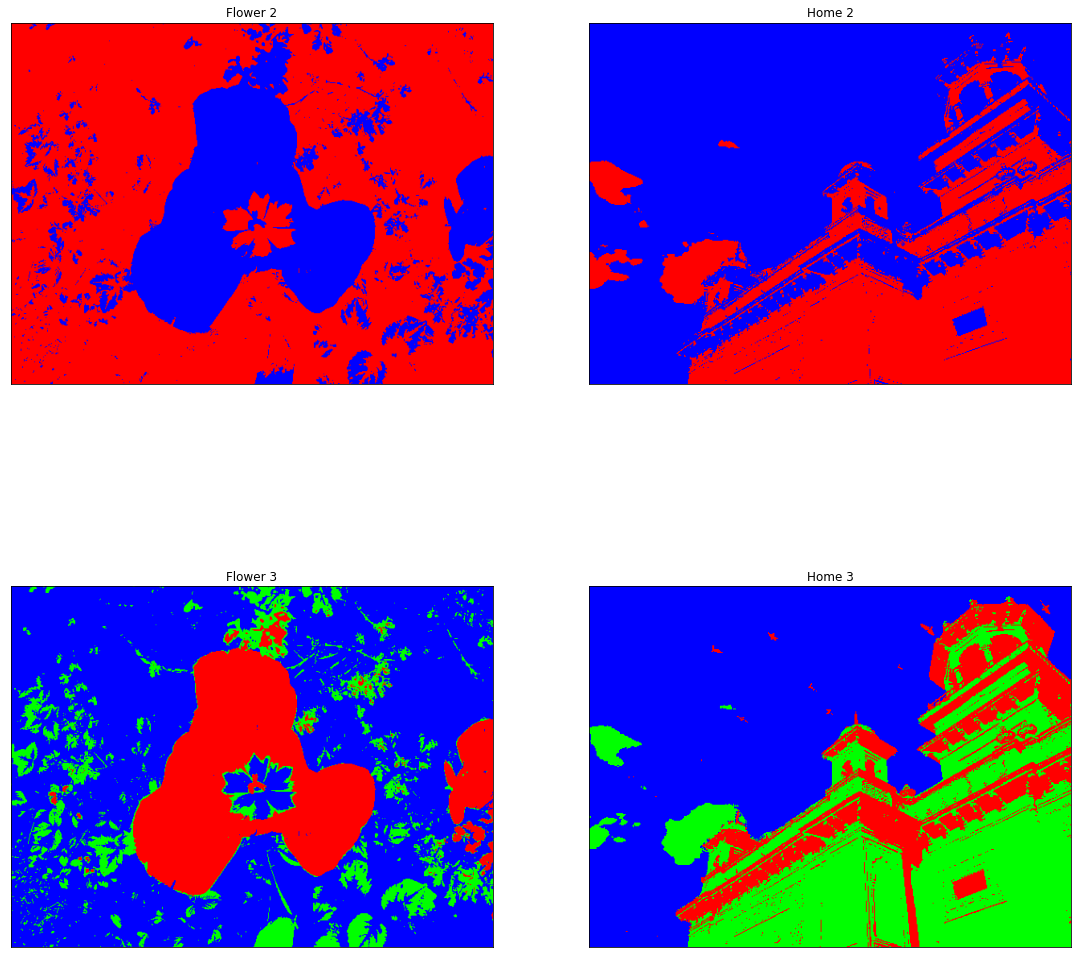

In [81]:

flower_seg2 = kseg(flower,2,10)
home_seg2 = kseg(home,2,10)
flower_seg3 = kseg(flower,3,10)
home_seg3 = kseg(home,3,10)
# display
plt.figure(figsize=(19,19))
plt.subplot(2,2,1), plt.imshow(flower_seg2)
plt.title("Flower 2"), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,2), plt.imshow(home_seg2)
plt.title("Home 2"), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,3), plt.imshow(flower_seg3)
plt.title("Flower 3"), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,4), plt.imshow(home_seg3)
plt.title("Home 3"), plt.xticks([]), plt.yticks([])
plt.show()

Disparity

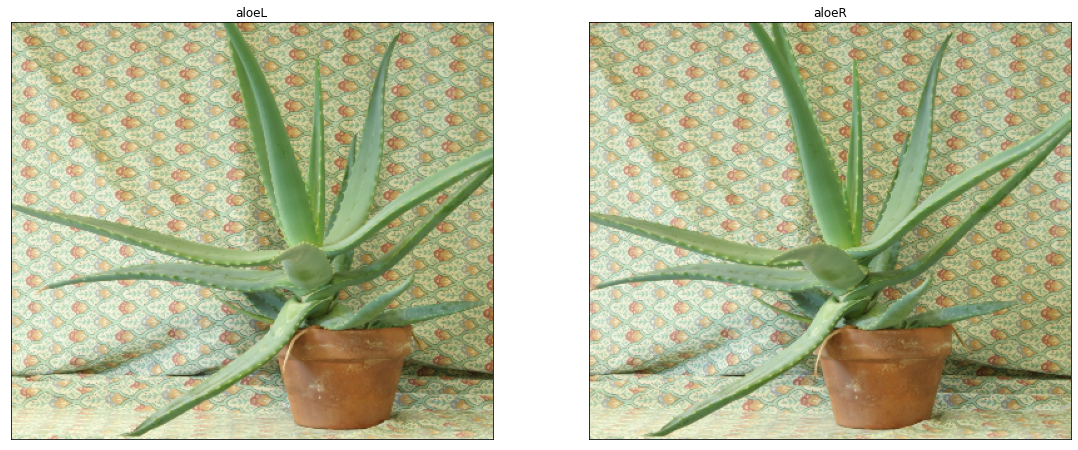

In [83]:
# Read in the image
aloeL = cv2.imread(path+'/aloeL.jpg') # use your own image path
aloeR = cv2.imread(path+'/aloeR.jpg') # use your own image path
aloeL = cv2.cvtColor(aloeL, cv2.COLOR_BGR2RGB) #convert to RGB
aloeR = cv2.cvtColor(aloeR, cv2.COLOR_BGR2RGB)
# resize images for fast processing
aloeL = cv2.resize(aloeL, None, fx=0.3, fy=0.3)
aloeR = cv2.resize(aloeR, None, fx=0.3, fy=0.3)
# display
plt.figure(figsize=(19,19))
plt.subplot(1,2,1), plt.imshow(aloeL)
plt.title("aloeL"), plt.xticks([]), plt.yticks([])
plt.subplot(1,2,2), plt.imshow(aloeR)
plt.title("aloeR"), plt.xticks([]), plt.yticks([])
plt.show()

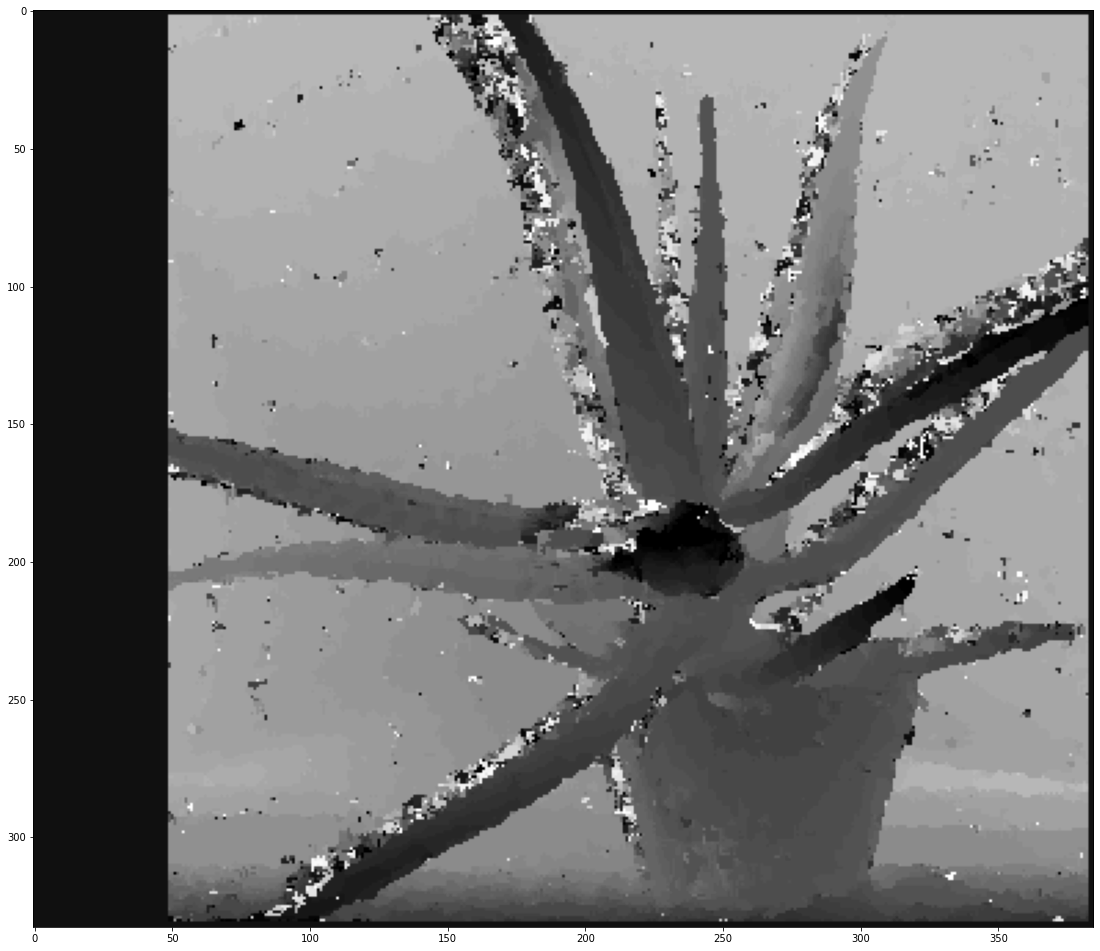

In [15]:
aloeL_copy = np.copy(aloeL)
aloeR_copy = np.copy(aloeR)
disparityMap = np.zeros(aloeL_copy.shape[:2])
shape = aloeL.shape
#Extract a 5 × 5 window centered at each pixel-location (i, j)L in the left
#image. Let’s call these windows reference windows.
disparityMap[:2] = 48 #For few boarder pixel-locations either the reference window or the search region lie outside the boundary of the image. Outside boudary of reference image 
disparityMap[:,:2] = 48
disparityMap[:,383:] = 48
disparityMap[331:,:] = 48
for i in range(shape[0]-4): #even though (i,j) start at 0,0 we are really looking at pixel (i+2,j+2) dealt with others earlier
  for j in range(shape[1]-4):
    refWindow = aloeL_copy[i:5+i,j:5+j] #get window of left image
    if ((j-47)<0):#if search window for this pixel is out of bounds just set to 48
      disparityMap[i+2][j+2] = 48
    else:
      minDifference = [0,0,50000] #pixel: (x,y,difference), don't need x but good for debugging
      for c in range(j-47,j): #go through scanline, (i,c)
        window =  aloeR_copy[i:5+i,c:5+c] 
        SSD = np.sum((refWindow - window)**2)
        if (minDifference[2]>SSD):
          minDifference[2] = SSD
          minDifference[0] = i #again not actually values of the pixel we are looking at, more top left of kernal
          minDifference[1] = c
      disparityMap[i+2][j+2] = j+2 - minDifference[1] + 2 #could get rid of the +2s but good for understanding

       
    #print(window)
plt.figure(figsize=(19,19))
plt.imshow(disparityMap,cmap="gray_r")

Optical Flow

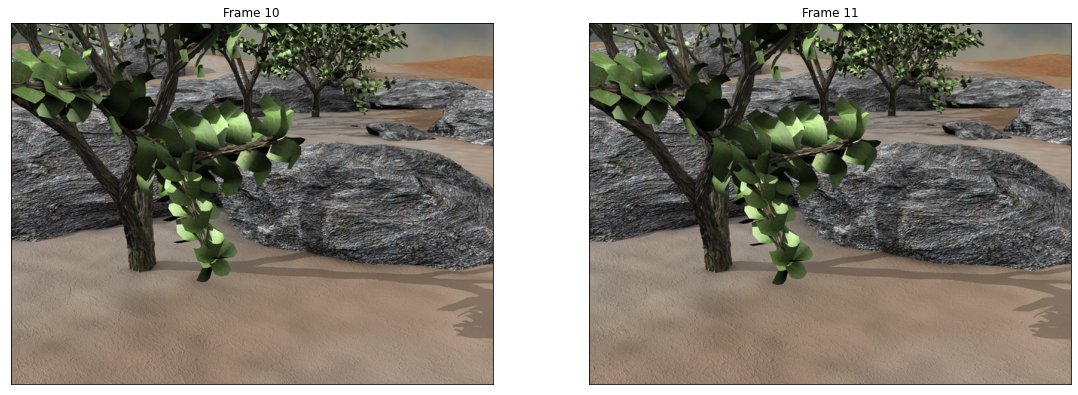

In [84]:
# Read in the image
frame10 = cv2.imread(path+'/frame10.png') # use your own image path
frame11 = cv2.imread(path+'/frame11.png') # use your own image path
frame10 = cv2.cvtColor(frame10, cv2.COLOR_BGR2RGB) #convert to RGB
frame11 = cv2.cvtColor(frame11, cv2.COLOR_BGR2RGB)

# display
plt.figure(figsize=(19,19))
plt.subplot(1,2,1), plt.imshow(frame10)
plt.title("Frame 10"), plt.xticks([]), plt.yticks([])
plt.subplot(1,2,2), plt.imshow(frame11)
plt.title("Frame 11"), plt.xticks([]), plt.yticks([])
plt.show()

In [29]:
# A function to help draw optical flow with flow lines (From tutorial)
def draw_flow(img, flow, step=16):
    h, w = img.shape[:2]
    y, x = np.mgrid[step/2:h:step, step/2:w:step].reshape(2,-1).astype(int)
    fx, fy = flow[y,x].T
    lines = np.vstack([x, y, x+fx, y+fy]).T.reshape(-1, 2, 2)
    lines = np.int32(lines + 0.5)
    vis = img.copy()#cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    cv2.polylines(vis, lines, 0, (0, 255, 0))
    for (x1, y1), (x2, y2) in lines:
        cv2.circle(vis, (x1, y1), 1, (0, 255, 0), -1)
    return vis

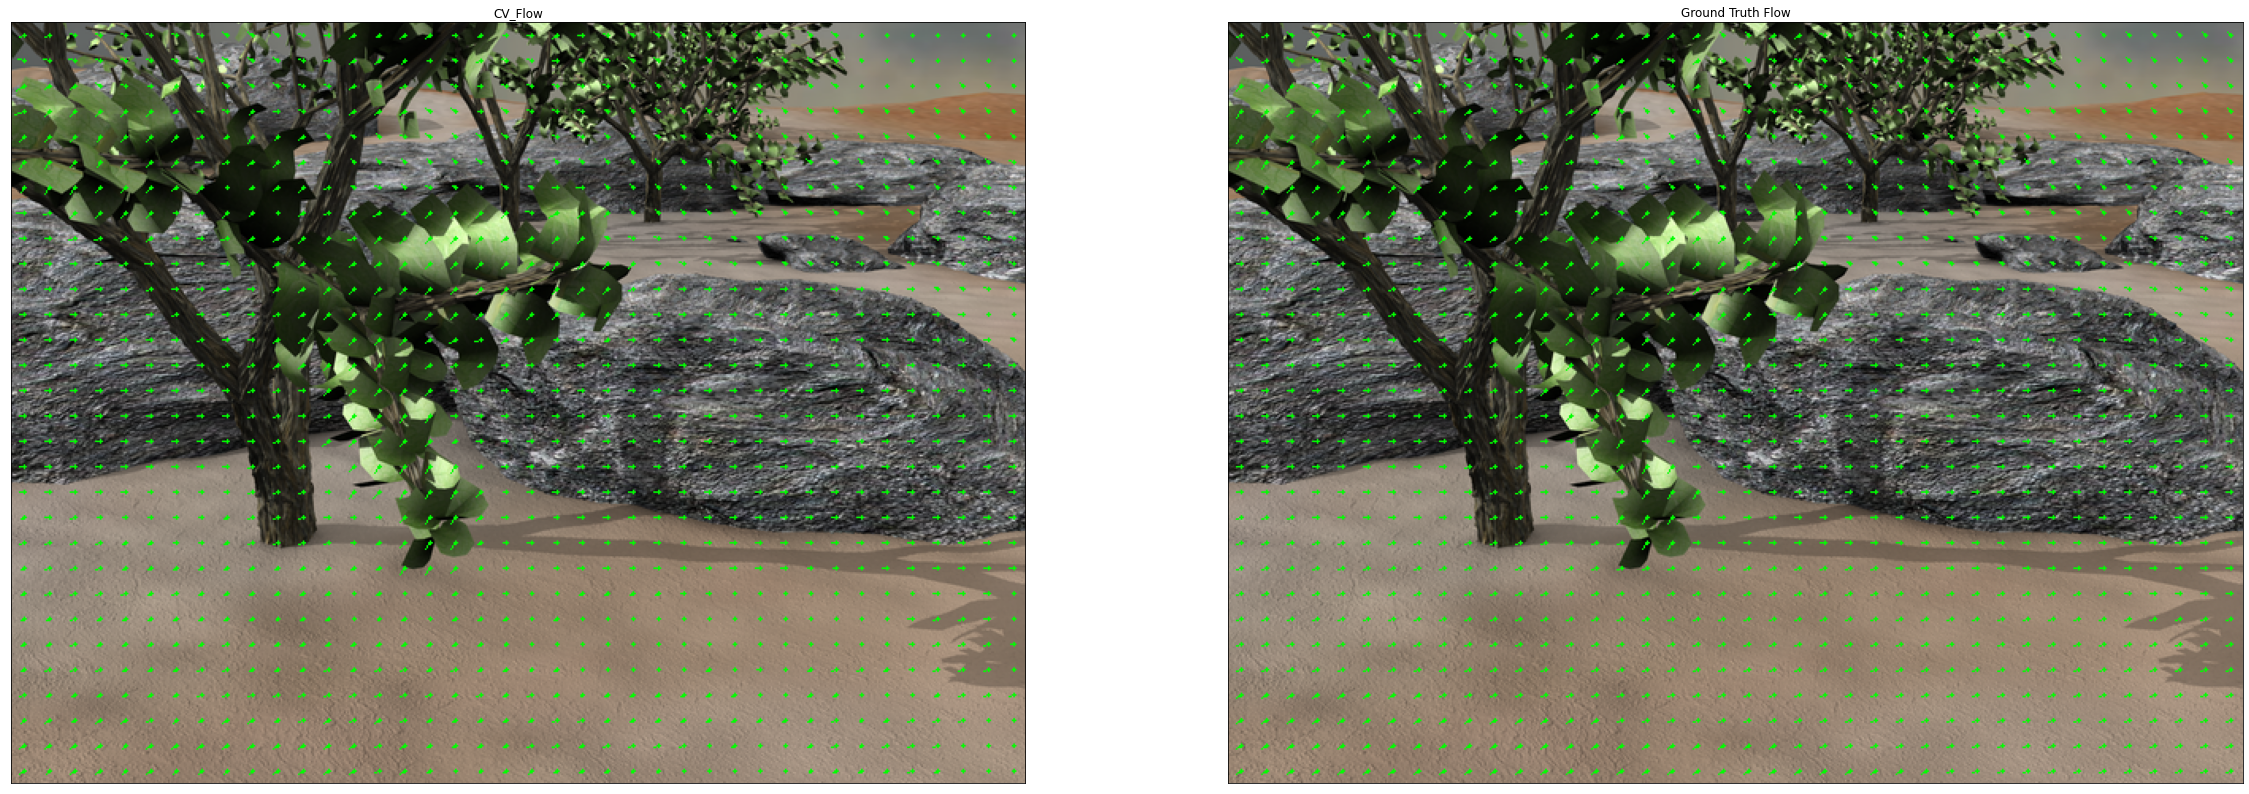

In [85]:
gt = np.load(path+'/flow10.npz')['flow'] #answer
gt_flow = draw_flow(frame10, gt)

frame10_BW = cv2.cvtColor(frame10, cv2.COLOR_BGR2GRAY)
frame11_BW = cv2.cvtColor(frame11, cv2.COLOR_BGR2GRAY)
#flow=None, pyr scale=0.5, levels=3, iterations=3, poly n=5,
#poly sigma=1.2 and flags=0.
def flowFunction(winS):
  flow = cv2.calcOpticalFlowFarneback(prev=frame10_BW, 
                                      next=frame11_BW, 
                                      flow=None,
                                      pyr_scale=0.5, 
                                      levels=3, 
                                      winsize=winS, #going to vary in next step
                                      iterations=3, 
                                      poly_n=5, 
                                      poly_sigma=1.2, 
                                      flags=0)
  return flow
flow_15 = flowFunction(15)
cv_flow = draw_flow(frame10, flow_15)

# display
plt.figure(figsize=(40,40))
plt.subplot(1,2,1), plt.imshow(cv_flow)
plt.title("CV_Flow"), plt.xticks([]), plt.yticks([])
plt.subplot(1,2,2), plt.imshow(gt_flow)
plt.title("Ground Truth Flow"), plt.xticks([]), plt.yticks([])
plt.show()

Text(0, 0.5, 'MSE')

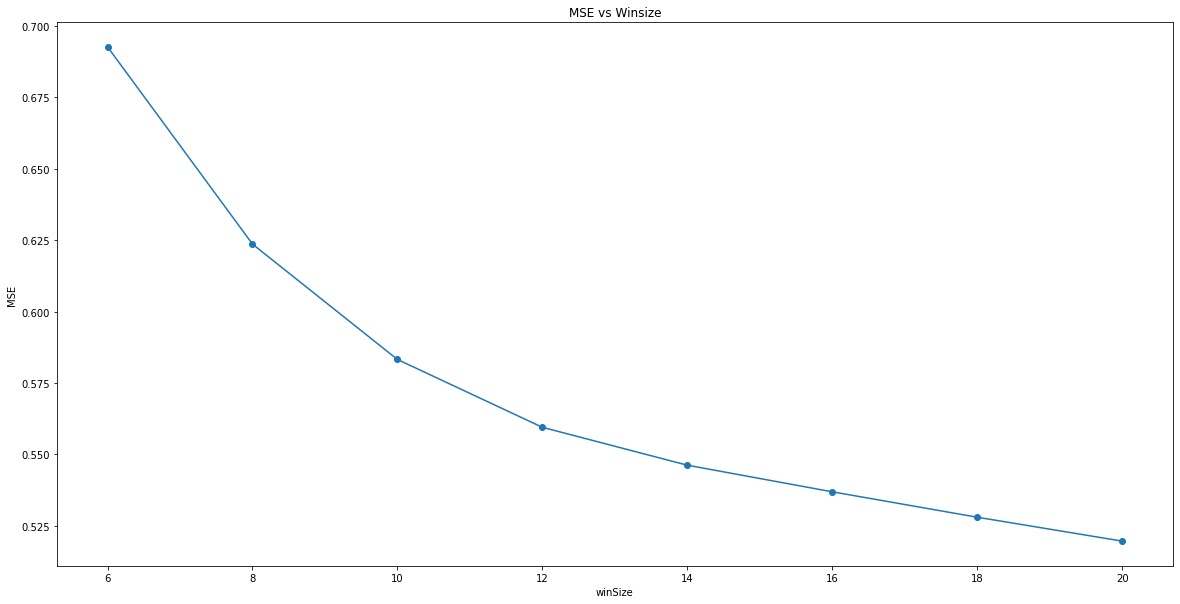

In [75]:
#For each setting of winsize, measure mean squared error(MSE) between
#estimated optical flow and the ground truth optical flow.
MSE = []
winSize = []
for i in range(5,21):
  if (i%2 == 1 ):
    pass
  else:
    currentFlow = flowFunction(i)
    mse = (np.square(gt - currentFlow)).mean(axis=None)
    MSE.append(mse)
    winSize.append(i)

#Plot MSE (y-axis) vs winsize (x-axis).
plt.figure(figsize=(20,10))
plt.plot(winSize,MSE,'-o')
plt.title('MSE vs Winsize')
plt.xlabel('winSize')
plt.ylabel('MSE')

Do you observe any trend in the plot above? Does the error increase or
decrease with increasing window-size? Explain the effect of window-size
on the prediction error.


The trend I observe is that as window-size increases, error goes down. The decrease is also exponential which is to say, the amount by which error decreases gets smaller as window size increases implying diminishing returns. I actually played around with this and tested with values up to 200 where at about a window size of 40 the error starts going up again. From this I make the conclusion that as you increase window size the blurryness and noise of the image has less affect on the MSE making the error smaller. Though only up to a point where your window size is too large (the pixel neighborhood too big) and error starts going back up.